# Домашнее задание 2. Прогнозирование с помощью моделей (S)ARIMA(X)

В этом домашнем задании рассматривается практическое применение модели SARIMA.

Эта модель — универсальный базовый инструмент. Если не знаешь с чего начать, SARIMA станет хорошим бейзлайном. Если у тебя при этом ещё и мало данных, то, скорее всего, она будет единственным адекватным вариантом наряду с ETS.


# 1. SARIMA как независимая модель (6 баллов)

Для начала попробуй применить модель как самостоятельную на очень простых данных. Например, в стандартном датасете квартальных данных по макроэкономике США выбери ряд численности населения.

In [1]:
!pip install sktime -q
!pip install -q "dask[dataframe]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 6.3 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sktime.datasets import load_macroeconomic
import pandas as pd

data = load_macroeconomic()
data.index = pd.date_range(start = '01.01.1959', periods = len(data), freq='QE')
data = data['pop']

### Train/test split

Раздели ряд на тренировочную и тестовую выборку, для теста возьми 20% последних наблюдений. Весь анализ проводи на тренировочной выборке.

In [4]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

In [5]:
import dask.dataframe

In [6]:
y_train, y_test = temporal_train_test_split(y=data, test_size=0.2)
fh = ForecastingHorizon(y_test.index, is_relative=False)

162 41


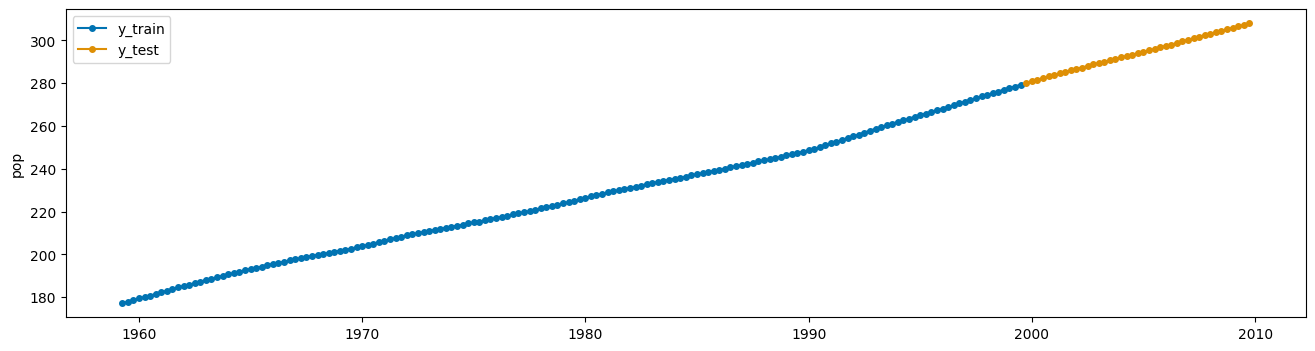

In [7]:
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

Исходя из описания на сайте Statsmodels, он представляет собой численность населения США на конец каждого квартала с учётом военнослужащих, находящихся за рубежом.

Структура модели представлена на картинке. Нотация B (Backshift) эквивалентна оператору лага. Период сезонности равен четырём.

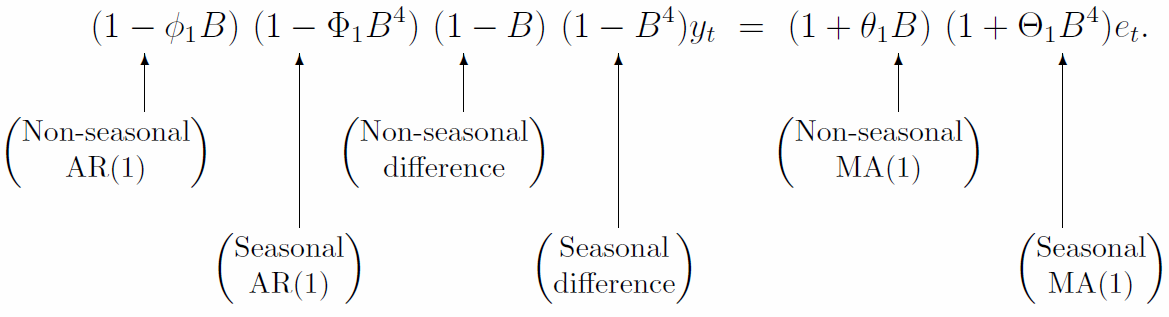


Разберём ещё раз подробно параметры и как их подбирать.
$$SARIMA(p,d,q)(P,D,Q)$$

Начнём с базовых:

- p — порядок авторегрессии;
- d — порядок интеграции;
- q — порядок скользящего среднего.

У каждого свой паттерн поведения автокорреляций.

- Для выбора параметра d используй тесты на стационарность. Нестационарность видно по характерному рисунку автокорреляций: ACF медленно убывает, а из PACF очень значима первая, а остальные близки к нулю.
- Для AR(p)-процесса частные автокорреляции обрываются на лаге p.
- Для MA(q)-процесса автокорреляции обрываются на лаге q.
- Для ARMA(p,q) — обе убывают. Обычно на практике просто перебирают все комбинации, ограничивая границы перебора максимально значимым порядком автокорреляций.

Сезонные параметры подбираются похожим способом. Так как SARIMA-модель с одним периодом сезонности, зафиксируй его. В примере даны месячные данные и, соответственно, месячная сезонность. В данных домашнего задания частота — квартал.

- Если в процессе сезонность представлена авторегрессией порядка P, то автокорреляции сезонных лагов (т.е. каждого 12-го лага) экспоненциально убывают, а частные автокорреляции сезонных лагов обрываются на порядке P.

- Если сезонность представлена скользящим средним порядка Q, то автокорреляции сезонных лагов (т.е. каждого 12-го лага) обрываются на порядке Q, а частные автокорреляции сезонных лагов экспоненциально убывают.

То есть подход не поменялся, и мы просто смотрим не на каждый лаг, а на каждый k-й лаг.

In [8]:
# твой код (видимо, выше)

### Графическое представление ВР
Визуализируй этот ряд, его автокорреляции и частные автокорреляции. Есть ли в нём тренд и сезонность?

In [9]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<Figure size 1200x600 with 0 Axes>

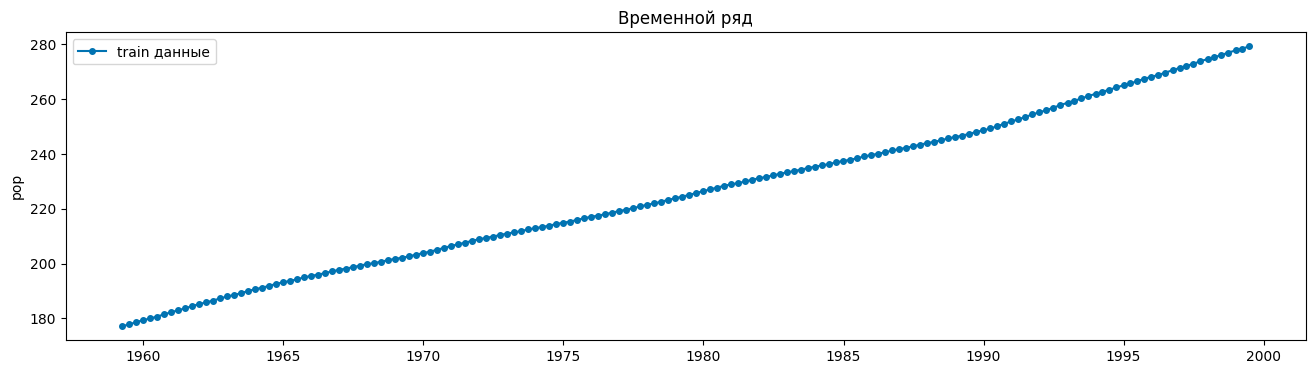

In [10]:
plt.figure(figsize=(12, 6))
plot_series(y_train, labels=['train данные'])
plt.title('Временной ряд')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

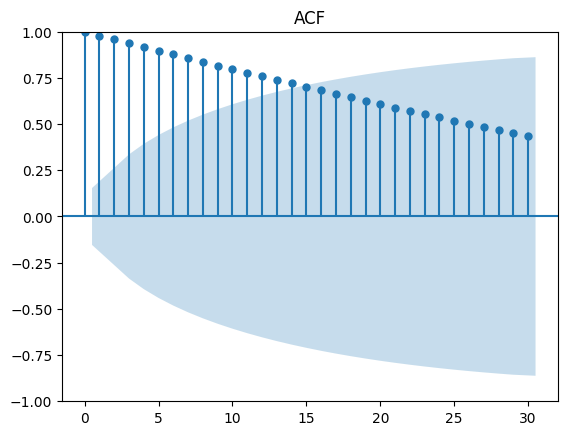

In [11]:
plt.figure(figsize=(12, 6))
plot_acf(y_train, lags=30)
plt.title('ACF')
plt.show()

<Figure size 1200x600 with 0 Axes>

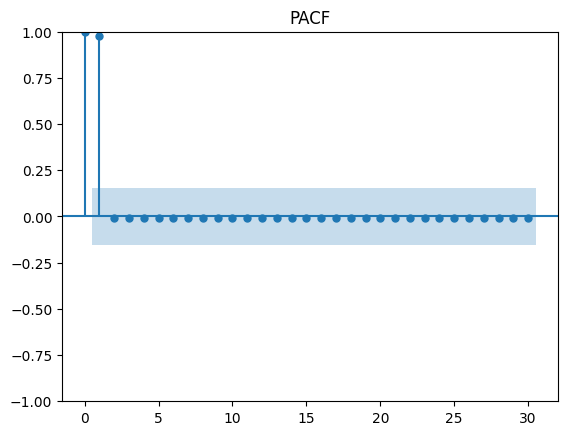

In [12]:
plt.figure(figsize=(12, 6))
plot_pacf(y_train, lags=30)
plt.title('PACF')
plt.show()


Выводы по графикам коротко:

+ Сначала сам временной ряд. По нему явно виден восходщий и стабильный тренд.Заметно устойчивое увеличение значения с течением времени. К слову, глазами я не вижу сезонности.

+ ACF: как я поняла, тот факт, что значения автокорреляции убывают плавно, тоже говорит о наличии тренда. Сезонность по графику не видна.

+ PACF: тут сильная корреляция на первых лагах, а потом все очень быстро падает почти до нуля. Вроде как это указывает на сильную автокорреляцию на коротких интервалах, можно брать какую-нибудь AR(1) модель.

Финализируем: тренд есть, сезонности нету.

Выполни тест ADF. Сделай вывод.

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
# твой код
result = adfuller(y_train, autolag='AIC', regression='ct')
print('ADF Stat:', result[0], '\n', 'p-value:', result[1], '\n', 'critical val:')
for key, value in result[4].items():
    print(f'{key}: {value}')


ADF Stat: 0.1532256536903986 
 p-value: 0.9954919297228337 
 critical val:
1%: -4.02127882271287
5%: -3.440581388836791
10%: -3.144706364874736


Ну, временной ряд нестационарный, высокое значение p-value, что ADF Stat выше критических значений...

Вычисли коэффициент Хёрста для временного ряда. Сделай вывод.

In [15]:
!pip install -q hurst

In [16]:
# твой код
from hurst import compute_Hc

H, c, data_reg = compute_Hc(y_train, kind='random_walk', simplified=True)

print(f"Hurst: {H}")

Hurst: 0.8339002435024137


Тут выходит, что результат еще раз свидетельствует о тренде, причем у временного ряда есть тенденция к продолжению тренда в будущем, какие-то сильные долгосрочные зависимости.

Выясни порядок интеграции ряда (параметр d) c помощью KPSS-теста. Нарисуй коррелограммы стационарной версии ряда.

In [17]:
# твой код
from statsmodels.tsa.stattools import kpss

statistic, p_value, n_lags, critical_values = kpss(y_train, regression='ct')
print(f'KPSS: {statistic}, p-value: {p_value}, critical val:')
print(f'Critical Values:')
for key, value in critical_values.items():
    print(f'{key} : {value}')

KPSS: 0.3269614532805976, p-value: 0.01, critical val:
Critical Values:
10% : 0.119
5% : 0.146
2.5% : 0.176
1% : 0.216


<ipython-input-17-796c882148c3>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(y_train, regression='ct')


ряд нестационарный, надо дифференцировать, вот ниже вычисляем порядок

In [18]:
import numpy as np

def find_integration_order(series):
    d = 0
    while True:
        statistic, p_value, _, _ = kpss(series, regression='ct')
        print(f'KPSS statistic: {statistic}, p-value: {p_value}')
        if p_value > 0.05:
            break
        series = np.diff(series)
        d += 1
    return d

d = find_integration_order(y_train)
print(f"Порядок интеграции: {d}")

KPSS statistic: 0.3269614532805976, p-value: 0.01
KPSS statistic: 0.32158701697352876, p-value: 0.01
KPSS statistic: 0.046634484513722714, p-value: 0.1
Порядок интеграции: 2


<ipython-input-18-9f9959a4b598>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, _, _ = kpss(series, regression='ct')
<ipython-input-18-9f9959a4b598>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, _, _ = kpss(series, regression='ct')
<ipython-input-18-9f9959a4b598>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, _, _ = kpss(series, regression='ct')


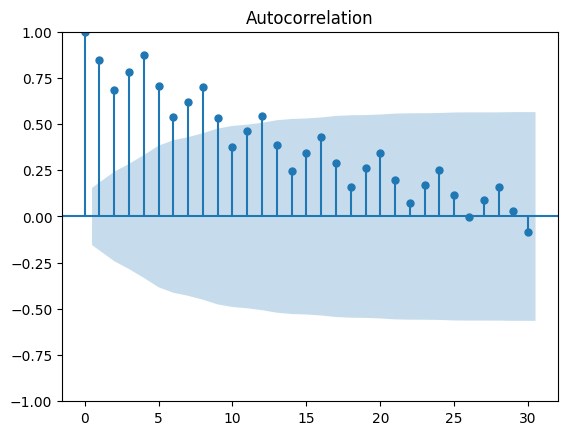

In [19]:
y_train_diff = y_train.diff(2).dropna()

plot_acf(y_train_diff, lags=30)
plt.show()

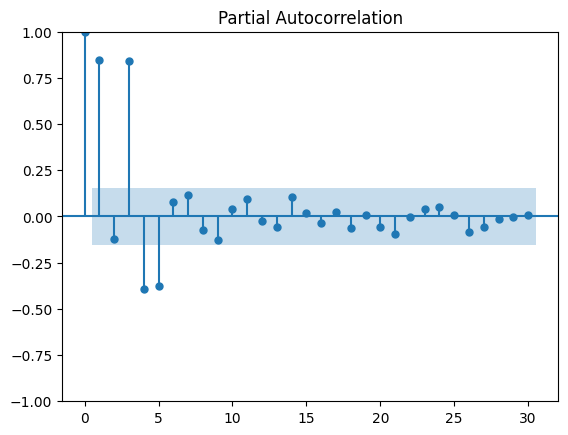

In [20]:
plot_pacf(y_train_diff, lags=30)
plt.show()

автокорреляции все еще есть, но плюс в том, что их поведение изменилось, остаточный тренд вроде как все еще есть

<Figure size 1200x600 with 0 Axes>

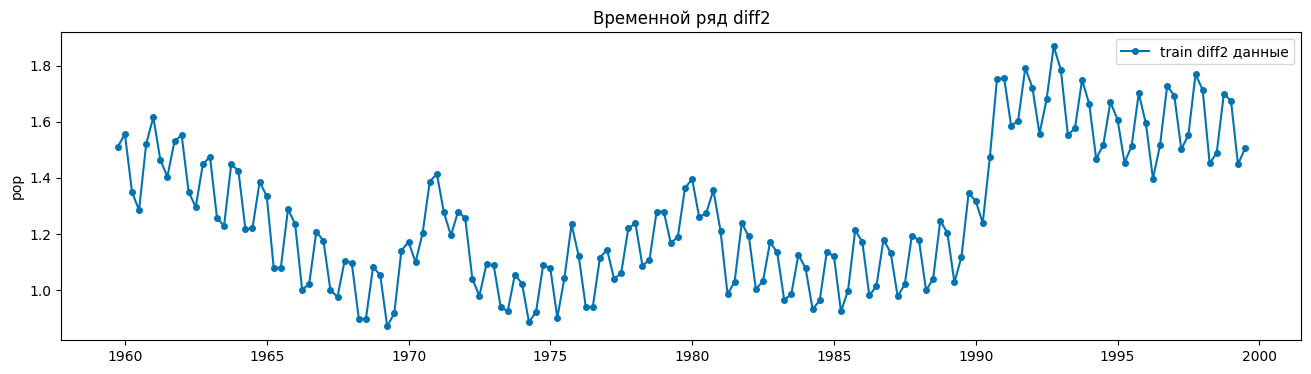

In [21]:
plt.figure(figsize=(12, 6))
plot_series(y_train_diff, labels=['train diff2 данные'])
plt.title('Временной ряд diff2')
plt.legend()
plt.show()

### Модель 1

По графикам автокорреляций из предыдущего пункта подбери значения (или по крайней мере границы значений) параметров p, q, P, Q. Обязательно аргументируй выбор каждого параметра. Без аргументации пункт не засчитывается.

+ p — порядок авторегрессии: по PACF нужно выбрать, на графике можно увидеть значительное превышение доверительного интервала на первых трех лагах, после третьего лага корреляция быстро затухает. Поэтому p=3.
- d — порядок интеграции, равен двум, так как там ряд становится стационарным.
- q — порядок скользящего среднего: ну, нет такого, что по графику прям что-то обрывается, но после лага 12 они переставют выходить за границы морковки. Но это много и странно, я поставила по итогу просто 1.

P (сезонная авторегрессия): На графиках автокорреляции тут появилась некоторая цикличность, каждый чевертый лаг чуток выше, так что смотрю на поведение каждого четвертого лага, после порядка три все обрывается на графике частичны автокорреляций, P поставлю равным 3.
Q поставлю равным 1, потому что автокорреляции плавно снижаются, но какого-то четкого резкого обрыва нет.

In [22]:
# твой код
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_1 = SARIMAX(y_train,
                order=(3, 2, 1),
                seasonal_order=(3, 1, 1, 4))

model_1_fit = model_1.fit(disp=False)
print(model_1_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                               pop   No. Observations:                  162
Model:             SARIMAX(3, 2, 1)x(3, 1, 1, 4)   Log Likelihood                 294.680
Date:                           Sun, 20 Oct 2024   AIC                           -571.361
Time:                                   11:08:05   BIC                           -543.912
Sample:                               03-31-1959   HQIC                          -560.212
                                    - 06-30-1999                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0559      8.946     -0.006      0.995     -17.591      17.479
ar.L2          0.0499      0.838      0.060

### Модель 2

Для рядов с сильной сезонностью можно производить отбор по-другому и сэкономить пару параметров. Для этого подбор нужно начать не с параметра d, а с параметра D.

Сезонная разность порядка 12, например, выражается следующим образом:
$$ \Delta y^{12}_t = y_t - y_{t-12.} $$


Обрати внимание, что сезонная разность выполняет двойную функцию.

1. Стандартным уменьшает порядок интеграции на единицу.

2. Фильтрует значительную часть сезонных автокорреляций. Логика абсолютно такая же, как с обычными автокорреляциями и трендами. Если привести ряд к стационарному, картина автокорреляций становится более очевидной. С сезонными лагами ситуация такая же: взятие сезонных разностей может сократить количество необходимых сезонных коэффициентов.

Так как сила сезонности после взятия разности уже не будет высокой, на практике D=2 никогда не возникает. Если же после взятия сезонных разностей ряд остаётся нестационарным, то можно дополнительно взять несколько раз обычные разности по стандартной процедуре.

Теперь вернись к исходным данным и попробуй повторить подбор параметров.

Подбери параметр D, а затем параметр d. Нарисуй коррелограммы стационарной версии ряда.

In [23]:
# твой код
s = 4
y_train_season_diff = y_train - y_train.shift(s)
y_train_season_diff = y_train_season_diff.dropna()

statistic, p_value, _, _ = kpss(y_train_season_diff)
print(f'KPSS statistic: {statistic}, p-value: {p_value}')

KPSS statistic: 0.6464258135262207, p-value: 0.01841583513397993


In [24]:
y_train_diff = y_train_season_diff.diff().dropna()
statistic, p_value, _, _ = kpss(y_train_diff)
print(f'KPSS statistic: {statistic}, p-value: {p_value}')

KPSS statistic: 0.20361803952799978, p-value: 0.1


<ipython-input-24-0c8ce2db2ba4>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, _, _ = kpss(y_train_diff)


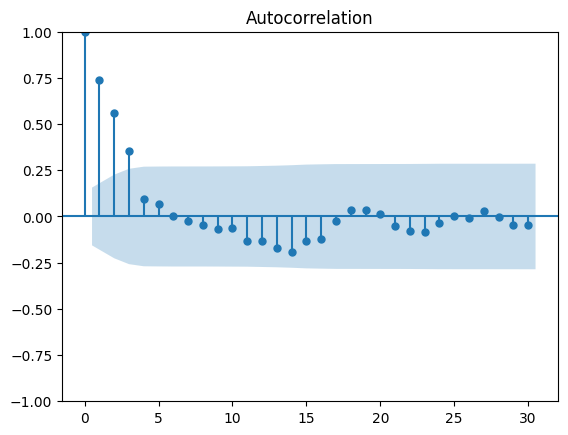

In [25]:
plot_acf(y_train_diff, lags=30)
plt.show()

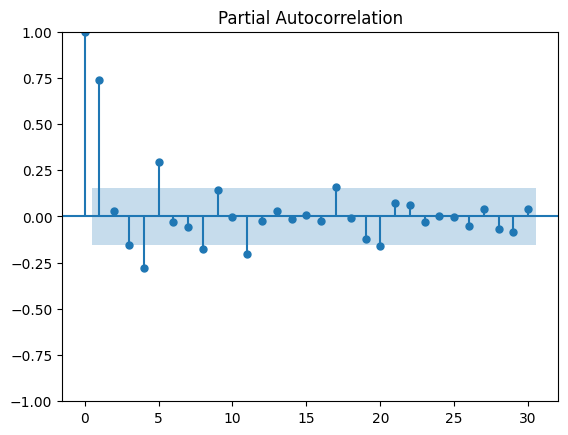

In [26]:
plot_pacf(y_train_diff, lags=30)
plt.show()

По графикам автокорреляций из предыдущего пункта подбери значения (или по крайней мере границы значений) параметров p, q, P, Q. Стал ли выбор параметров проще и очевиднее? Обязательно аргументируй выбор каждого параметра. Без аргументации пункт не засчитывается.

Тут получается, что
+ p по графику равен где-то 1, так как на PACF видно, что значительная автокорреляция наблюдается на первых лагах, после чего она быстро падает и становится незначительной.

+ q = 3, так как по ACF видим, что автокорреляции уменьшаются медленно, но величина автокорреляции падает в пределах 2-3 лага, что может указывать на q = 2 или 3.

+ P = 0 для сезонных компонент на графике PACF автокорреляции незначительны, что говорит о том, что параметр P скорее всего равен 0.

+ Q = 1, так как по ACF видно, что автокорреляции сезонных лагов очень быстро обрываются как раз примерно к 4-му лагу.

In [27]:
# твой код
model_2 = SARIMAX(y_train,
                order=(1, 1, 3),
                seasonal_order=(0, 1, 1, 4))

model_2_fit = model_2.fit(disp=False)
print(model_2_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 pop   No. Observations:                  162
Model:             SARIMAX(1, 1, 3)x(0, 1, [1], 4)   Log Likelihood                 306.857
Date:                             Sun, 20 Oct 2024   AIC                           -601.714
Time:                                     11:08:07   BIC                           -583.376
Sample:                                 03-31-1959   HQIC                          -594.266
                                      - 06-30-1999                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0288      0.079     -0.365      0.715      -0.183       0.126
ma.L1          0.8696      

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Модель 3

Используя функцию `auto_arima` и алгоритм Hyndman — Khandakar, подбери модель.

In [28]:
!pip install -q pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.6 MB/s eta 0:00:00


In [29]:
# твой код
from pmdarima import auto_arima

model_3 = auto_arima(y_train, seasonal=True, m=4,
                   start_p=0, start_q=0, max_p=5, max_q=5,
                   start_P=0, start_Q=0, max_P=5, max_Q=5,
                   d=None, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True)

print(model_3.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=-436.236, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-584.573, Time=0.86 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-521.184, Time=0.71 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=-557.954, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=-592.498, Time=1.85 sec
 ARIMA(1,1,0)(3,1,0)[4]             : AIC=-591.683, Time=2.04 sec
 ARIMA(1,1,0)(2,1,1)[4]             : AIC=-601.289, Time=2.63 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=-603.230, Time=1.59 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-604.738, Time=0.99 sec
 ARIMA(1,1,0)(0,1,2)[4]             : AIC=-603.202, Time=1.78 sec
 ARIMA(1,1,0)(1,1,2)[4]             : AIC=-601.210, Time=5.95 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-435.790, Time=0.63 sec
 ARIMA(2,1,0)(0,1,1)[4]             : AIC=-604.083, Time=2.28 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=-603.968, Time=3.17 sec
 ARIMA(2,1,1)(0,1,1)[4]          

### Интервальные оценки

Для тестовой выборки построй интервальные оценки надёжности 80 и 95% для всех трёх моделей. Оцени качество интервальных оценок. Какую из моделей кажется тебе более адекватной и почему?

In [30]:
def interval_coverage(test_data, conf_int, alpha):
    within_interval = np.sum((test_data >= conf_int.iloc[:, 0]) & (test_data <= conf_int.iloc[:, 1]))
    total_points = len(test_data)
    coverage = within_interval / total_points
    print(f"confidence interval coverage alpha = {alpha}: {coverage*100:.2f}%")
    return coverage

In [31]:
forecast_steps = len(y_test)

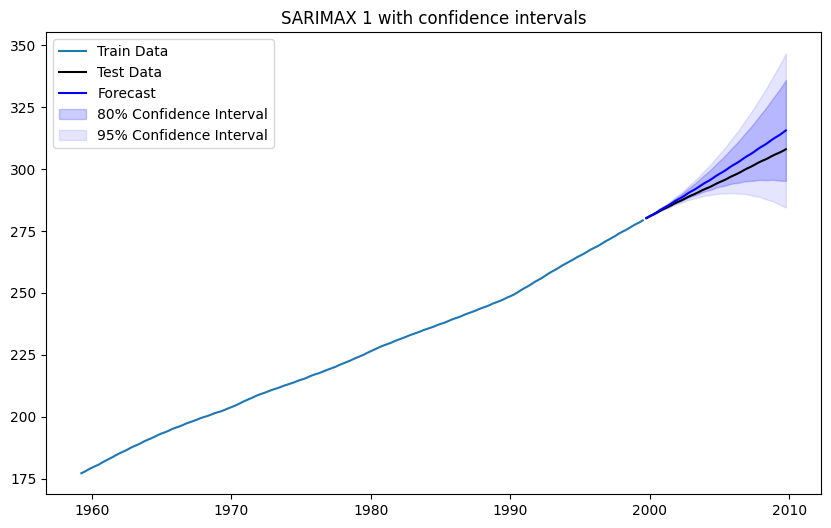

In [33]:
pred_1 = model_1_fit.get_prediction(start=len(y_train), end=len(y_train) + forecast_steps - 1)
pred_1_conf_95 = pred_1.conf_int(alpha=0.05)
pred_1_conf_80 = pred_1.conf_int(alpha=0.2)
forecast_1 = pred_1.predicted_mean

plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Train Data')
plt.plot(y_test.index, y_test, label='Test Data', color='black')
plt.plot(y_test.index, forecast_1, label='Forecast', color='blue')
plt.fill_between(y_test.index, pred_1_conf_80.iloc[:, 0], pred_1_conf_80.iloc[:, 1], color='blue', alpha=0.2, label='80% Confidence Interval')
plt.fill_between(y_test.index, pred_1_conf_95.iloc[:, 0], pred_1_conf_95.iloc[:, 1], color='blue', alpha=0.1, label='95% Confidence Interval')
plt.legend()
plt.title('SARIMAX 1 with confidence intervals')
plt.show()

In [ ]:
interval_coverage(y_test, pred_1_conf_95, alpha=0.05), interval_coverage(y_test, pred_1_conf_80, alpha=0.2)

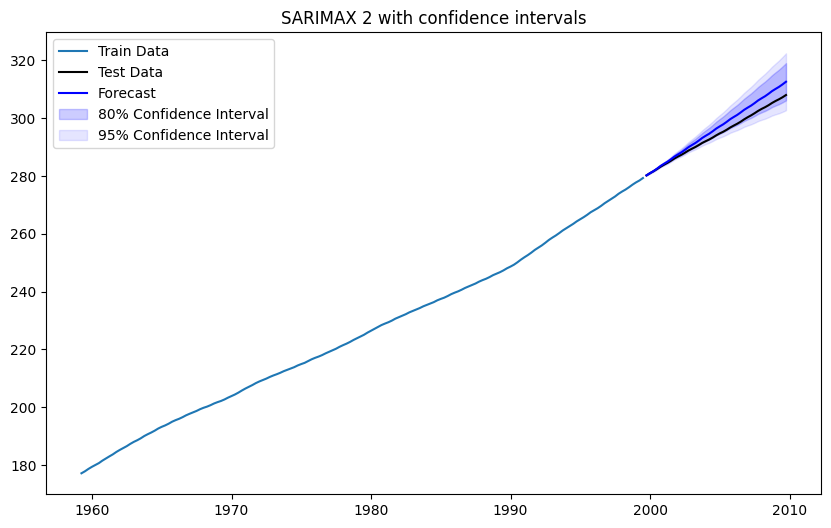

In [34]:
pred_2 = model_2_fit.get_prediction(start=len(y_train), end=len(y_train) + forecast_steps - 1)
pred_2_conf_95 = pred_2.conf_int(alpha=0.05)
pred_2_conf_80 = pred_2.conf_int(alpha=0.2)

forecast_2 = pred_2.predicted_mean

plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Train Data')
plt.plot(y_test.index, y_test, label='Test Data', color='black')
plt.plot(y_test.index, forecast_2, label='Forecast', color='blue')
plt.fill_between(y_test.index, pred_2_conf_80.iloc[:, 0], pred_2_conf_80.iloc[:, 1], color='blue', alpha=0.2, label='80% Confidence Interval')
plt.fill_between(y_test.index, pred_2_conf_95.iloc[:, 0], pred_2_conf_95.iloc[:, 1], color='blue', alpha=0.1, label='95% Confidence Interval')
plt.legend()
plt.title('SARIMAX 2 with confidence intervals')
plt.show()

In [35]:
interval_coverage(y_test, pred_2_conf_95, alpha=0.05), interval_coverage(y_test, pred_2_conf_80, alpha=0.2)

confidence interval coverage alpha = 0.05: 100.00%
confidence interval coverage alpha = 0.2: 100.00%


(1.0, 1.0)

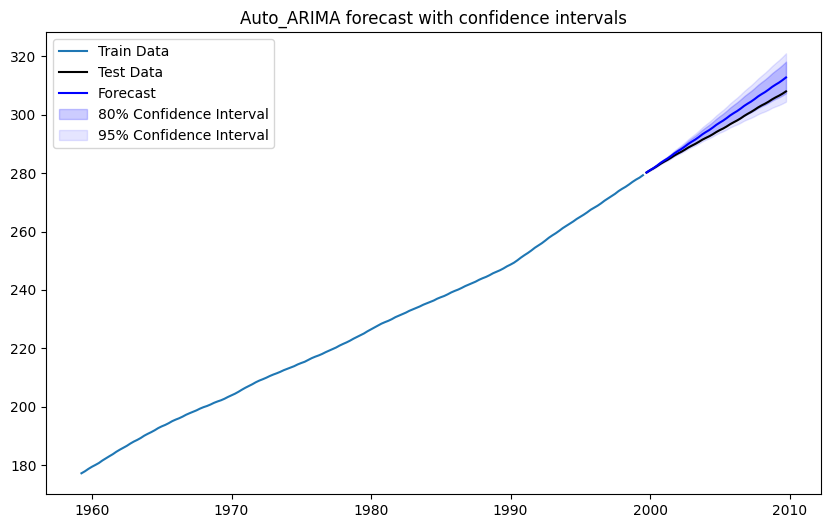

In [36]:
forecast_3, conf_int_3_80 = model_3.predict(n_periods=forecast_steps, return_conf_int=True, alpha=0.20)
forecast_3, conf_int_3_95 = model_3.predict(n_periods=forecast_steps, return_conf_int=True, alpha=0.05)

plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Train Data')
plt.plot(y_test.index, y_test, label='Test Data', color='black')
plt.plot(y_test.index, forecast_3, label='Forecast', color='blue')
plt.fill_between(y_test.index, conf_int_3_80[:, 0], conf_int_3_80[:, 1], color='blue', alpha=0.2, label='80% Confidence Interval')
plt.fill_between(y_test.index, conf_int_3_95[:, 0], conf_int_3_95[:, 1], color='blue', alpha=0.1, label='95% Confidence Interval')
plt.legend()
plt.title('Auto_ARIMA forecast with confidence intervals')
plt.show()

In [37]:
def interval_coverage_2(test_data, conf_int, alpha):
    within_interval = np.sum((test_data >= conf_int[:, 0]) & (test_data <= conf_int[:, 1]))
    total_points = len(test_data)
    coverage = within_interval / total_points
    print(f"confidence interval coverage alpha = {alpha}: {coverage*100:.2f}%")
    return coverage

In [38]:
interval_coverage_2(y_test, conf_int_3_80, 0.20), interval_coverage_2(y_test, conf_int_3_95, 0.05)

confidence interval coverage alpha = 0.2: 39.02%
confidence interval coverage alpha = 0.05: 100.00%


(0.3902439024390244, 1.0)

Интервальные оценки лучше всего у второй модели получились, они уже, чем у первой модели и покрытие 100%, в отличие от третьей модели.  Так что вторую модель я бы назвала самой адекватной.

### Анализ остатков

Проведи анализ остатков трёх моделей. Какая модель лучше и почему?

In [39]:
import seaborn as sns

In [40]:
residuals_1 = model_1_fit.resid
residuals_2 = model_2_fit.resid
residuals_3 = model_3.resid()

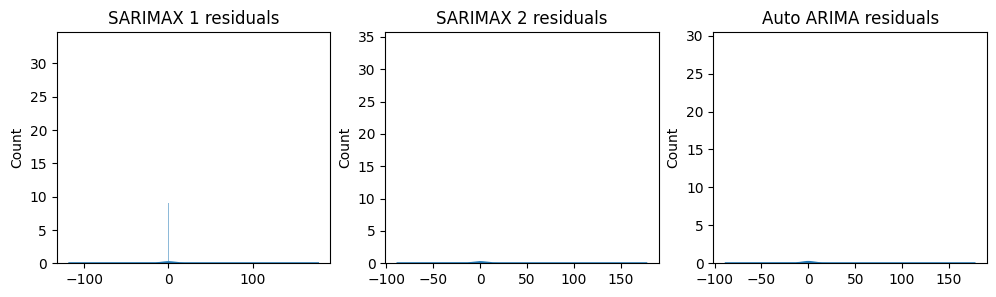

In [41]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
sns.histplot(residuals_1, kde=True)
plt.title('SARIMAX 1 residuals')

plt.subplot(132)
sns.histplot(residuals_2, kde=True)
plt.title('SARIMAX 2 residuals')

plt.subplot(133)
sns.histplot(residuals_3, kde=True)
plt.title('Auto ARIMA residuals')

plt.show()

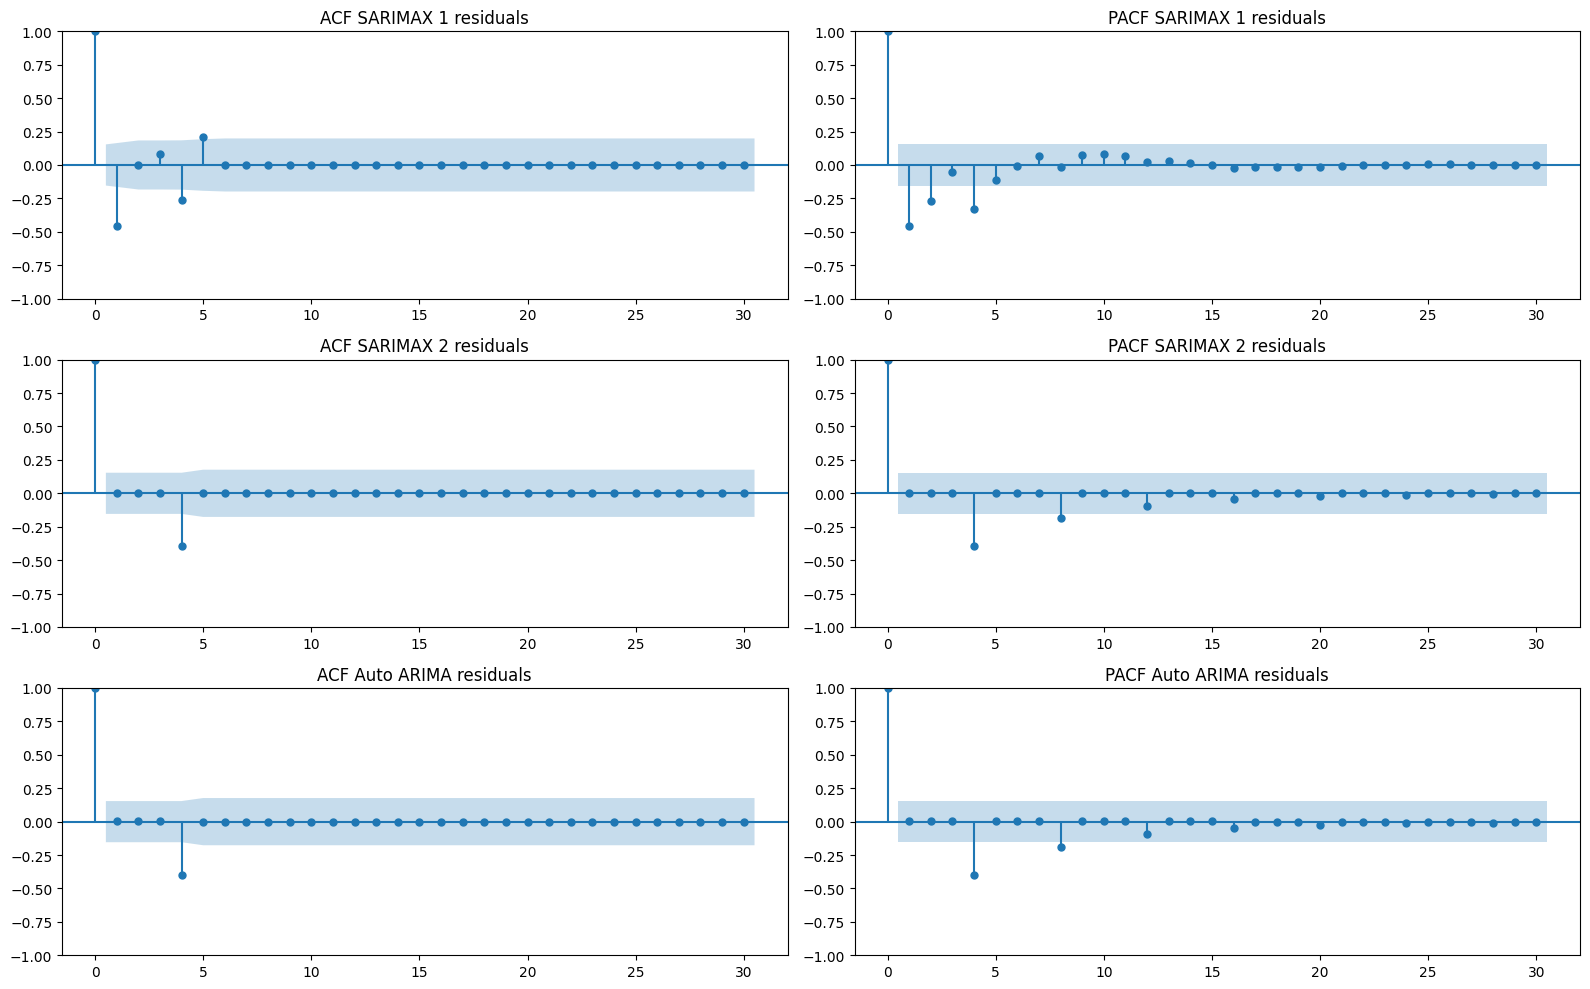

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(16, 10))

plot_acf(residuals_1, lags=30, ax=axes[0, 0])
plot_pacf(residuals_1, lags=30, ax=axes[0, 1])
axes[0, 0].set_title("ACF SARIMAX 1 residuals")
axes[0, 1].set_title("PACF SARIMAX 1 residuals")

plot_acf(residuals_2, lags=30, ax=axes[1, 0])
plot_pacf(residuals_2, lags=30, ax=axes[1, 1])
axes[1, 0].set_title("ACF SARIMAX 2 residuals")
axes[1, 1].set_title("PACF SARIMAX 2 residuals")

plot_acf(residuals_3, lags=30, ax=axes[2, 0])
plot_pacf(residuals_3, lags=30, ax=axes[2, 1])
axes[2, 0].set_title("ACF Auto ARIMA residuals")
axes[2, 1].set_title("PACF Auto ARIMA residuals")

plt.tight_layout()
plt.show()

In [43]:
import statsmodels.api as sm

In [44]:
lb_test_1 = sm.stats.acorr_ljungbox(residuals_1, lags=[30], return_df=True)
lb_test_2 = sm.stats.acorr_ljungbox(residuals_2, lags=[30], return_df=True)
lb_test_3 = sm.stats.acorr_ljungbox(residuals_3, lags=[30], return_df=True)

print(f"Ljung-Box test SARIMAX 1: {lb_test_1}")
print(f"Ljung-Box test SARIMAX 2: {lb_test_2}")
print(f"Ljung-Box test Auto ARIMA model: {lb_test_3}")

Ljung-Box test SARIMAX 1:       lb_stat  lb_pvalue
30  54.995317   0.003554
Ljung-Box test SARIMAX 2:       lb_stat  lb_pvalue
30  26.601382   0.644116
Ljung-Box test Auto ARIMA model:       lb_stat  lb_pvalue
30  26.600968   0.644137


Модели 2 и 3 оказались близки по графикам автокорреляции и частичной автокорреляции, а вот графики первой модели выглядят хуже. Тест Льюнга-Бокса тоже показывает, что вторые две модели лучше, правда, разница между ними невелика

### Сравнение моделей

Сравни две полученные ранее модели и модель, выбранную автоматическим алгоритмом. Для сравнения используй AICc и RMSE на тестовой выборке. Горизонт прогнозирования — 12 месяцев.

In [45]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [46]:
# твой код
forecast_horizon = 4 #12 месяцев - это 4 квартала

forecast_1 = model_1_fit.get_forecast(steps=forecast_horizon)
mean_forecast_1 = forecast_1.predicted_mean
rmse_1 = sqrt(mean_squared_error(y_test[:forecast_horizon], mean_forecast_1))

forecast_2 = model_2_fit.get_forecast(steps=forecast_horizon)
mean_forecast_2 = forecast_2.predicted_mean
rmse_2 = sqrt(mean_squared_error(y_test[:forecast_horizon], mean_forecast_2))

forecast_3 = model_3.predict(n_periods=forecast_horizon)
rmse_3 = sqrt(mean_squared_error(y_test[:forecast_horizon], forecast_3))


def calculate_aicc(aic, n, k):
    return aic + (2 * k * (k + 1)) / (n - k - 1)

aic_1 = model_1_fit.aic
n1 = len(y_train)
k1 = model_1_fit.df_model
aicc_1 = calculate_aicc(aic_1, n1, k1)

aic_2 = model_2_fit.aic
n2 = len(y_train)
k2 = model_2_fit.df_model
aicc_2 = calculate_aicc(aic_2, n2, k2)

aicc_3 = model_3.aicc()

metrics = pd.DataFrame({'model': ['1', '2', '3'], 'RMSE': [rmse_1, rmse_2, rmse_3], 'AICc': [aicc_1, aicc_2, aicc_3]})
metrics

,model,RMSE,AICc
0,1,0.11669,-570.176381
1,2,0.07317,-601.171823
2,3,0.09970,-604.585907


Ну, тут вторая модель лучше всего.

Проведи кросс-валидацию расширяющимся окном. Размер окна и начальной выборки определи самостоятельно. Какая модель на кросс-валидации лучше?

In [47]:
y_train.size

162

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
# твой код
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
initial_window_size = 20
rmse_scores_1 = []
rmse_scores_2 = []
rmse_scores_3 = []

for train_index, test_index in tscv.split(y_train):
    X_train, X_test = y_train[train_index], y_train[test_index]
    model_1 = SARIMAX(X_train, order=(3, 2, 1), seasonal_order=(3, 1, 1, 4))
    model_1_fit = model_1.fit(disp=False)
    forecast_1 = model_1_fit.get_forecast(steps=len(X_test)).predicted_mean
    rmse_1 = sqrt(mean_squared_error(X_test, forecast_1))
    rmse_scores_1.append(rmse_1)

    model_2 = SARIMAX(X_train, order=(1, 1, 3), seasonal_order=(0, 1, 1, 4))
    model_2_fit = model_2.fit(disp=False)
    forecast_2 = model_2_fit.get_forecast(steps=len(X_test)).predicted_mean
    rmse_2 = sqrt(mean_squared_error(X_test, forecast_2))
    rmse_scores_2.append(rmse_2)

    model_3 = auto_arima(X_train, seasonal=True, m=4, start_p=0, start_q=0, max_p=5, max_q=5,
                         start_P=0, start_Q=0, max_P=5, max_Q=5, d=None, D=1, trace=False,
                         error_action='ignore', suppress_warnings=True, stepwise=True)
    forecast_3 = model_3.predict(n_periods=len(X_test))
    rmse_3 = sqrt(mean_squared_error(X_test, forecast_3))
    rmse_scores_3.append(rmse_3)

avg_rmse_1 = np.mean(rmse_scores_1)
avg_rmse_2 = np.mean(rmse_scores_2)
avg_rmse_3 = np.mean(rmse_scores_3)

In [49]:
metrics_rmse = pd.DataFrame({'model': ['1', '2', '3'], 'RMSE': [avg_rmse_1, avg_rmse_2, avg_rmse_3]})
metrics_rmse

,model,RMSE
0,1,2.104796
1,2,0.847508
2,3,1.391132


Модель 2 все еще лучше всего

### График прогнозов

Построй прогнозы трёх моделей на тестовый период и визуализируй их на графике вместе с тестовыми данными. Желательно на графике захватывать несколько лет трейна.

In [ ]:
# твой код
# уже визуализировано выше

#### Преобразования

Имеет ли смысл делать предварительное преобразование Бокса — Кокса для ряда? Повышается ли от этого точность? Проверку провести для твоей лучшей модели.

Ну, тут логика такая, раз уже мы смотрим на RMSE, то сравниваем RMSE до и после преобразования. Если RMSE после преобразования заметно снизилась, то это указывает на улучшение точности модели благодаря преобразованию. А иначе нет смысла.

In [53]:
from scipy import stats

In [56]:
# твой код
def boxcox_inverse(y, lambda_, shift):
    y = np.array(y)
    if lambda_ == 0:
        return np.exp(y) - shift
    else:
        return np.power(y * lambda_ + 1, 1 / lambda_) - shift

y_train_boxcox, lambda_ = stats.boxcox(y_train)
model_boxcox = SARIMAX(y_train_boxcox, order=(1, 1, 3), seasonal_order=(0, 1, 1, 4))
model_boxcox_fit = model_boxcox.fit(disp=False)

f_boxcox = model_boxcox_fit.forecast(steps=len(y_test))
f_boxcox_inv = boxcox_inverse(f_boxcox, lambda_, 0)

rmse_boxcox = sqrt(mean_squared_error(y_test, f_boxcox_inv))

print(f"RMSE после применения преобразования: {rmse_boxcox}")


RMSE после применения преобразования: 3.612458131921341


Стало хуже, тут модели не нужно это преобразование предварительно.

## Бонус (+1 балл)

Попробуй три библиотеки для построения автоматических прогнозов с помощью модели ARIMA: pmdarima, statsforecast и statsmodels. Оцени время построения прогноза и его точность.

In [58]:
!pip install -q statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.4/271.4 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 8.2 MB/s eta 0:00:00


In [60]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsforecast.models import AutoARIMA
import time
from statsforecast import StatsForecast

In [67]:
# твой код
start_time = time.time()
model_pmdarima = auto_arima(y_train, seasonal=True, m=4,
                            start_p=0, start_q=0, max_p=5, max_q=5,
                            start_P=0, start_Q=0, max_P=5, max_Q=5,
                            d=None, D=1, trace=False,
                            error_action='ignore', suppress_warnings=True, stepwise=True)
forecast_pmdarima = model_pmdarima.predict(n_periods=len(y_test))
time_pmdarima = time.time() - start_time
rmse_pmdarima = sqrt(mean_squared_error(y_test, forecast_pmdarima))

start_time = time.time()
model_statsmodels = SARIMAX(y_train, order=(1, 1, 3), seasonal_order=(0, 1, 1, 4))
model_statsmodels_fit = model_statsmodels.fit(disp=False)
forecast_statsmodels = model_statsmodels_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
time_statsmodels = time.time() - start_time
rmse_statsmodels = sqrt(mean_squared_error(y_test, forecast_statsmodels))

In [71]:
df_train = pd.DataFrame({'unique_id': 'ts1', 'ds': y_train.index, 'y': y_train.values})
df_test = pd.DataFrame({'unique_id': 'ts1', 'ds': y_test.index, 'y': y_test.values})

start_time = time.time()
model_statsforecast = StatsForecast(models=[AutoARIMA(season_length=4)], freq='Q')
model_statsforecast.fit(df_train)
forecast_statsforecast = model_statsforecast.forecast(len(y_test), df_test)
time_statsforecast = time.time() - start_time
rmse_statsforecast = sqrt(mean_squared_error(y_test, forecast_statsforecast['AutoARIMA']))

In [72]:
metrics_3 = pd.DataFrame({'model': ['1', '2', '3'], 'time': [time_pmdarima, time_statsmodels, time_statsforecast], 'RMSE': [rmse_pmdarima, rmse_statsmodels, rmse_statsforecast]})
metrics_3

,model,time,RMSE
0,1,8.361296,2.758751
1,2,0.855137,2.629163
2,3,2.661355,14.429918


По соотношению время-точность лучше всего вторая модель

# 2. SARIMA+X (4 балла)

Теперь — к полному набору данных.

Описание датасета — https://www.statsmodels.org/dev/datasets/generated/macrodata.html.

In [75]:
macro_econ_data  = load_macroeconomic()
macro_econ_data .index = pd.date_range(start = '01.01.1959', periods = len(data), freq='QE')
macro_econ_data

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...
2008-09-30,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008-12-31,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009-03-31,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
2009-06-30,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


Или из библиотки statmodels, здесь формат даты другой.

In [76]:
import statsmodels.api as sm

macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


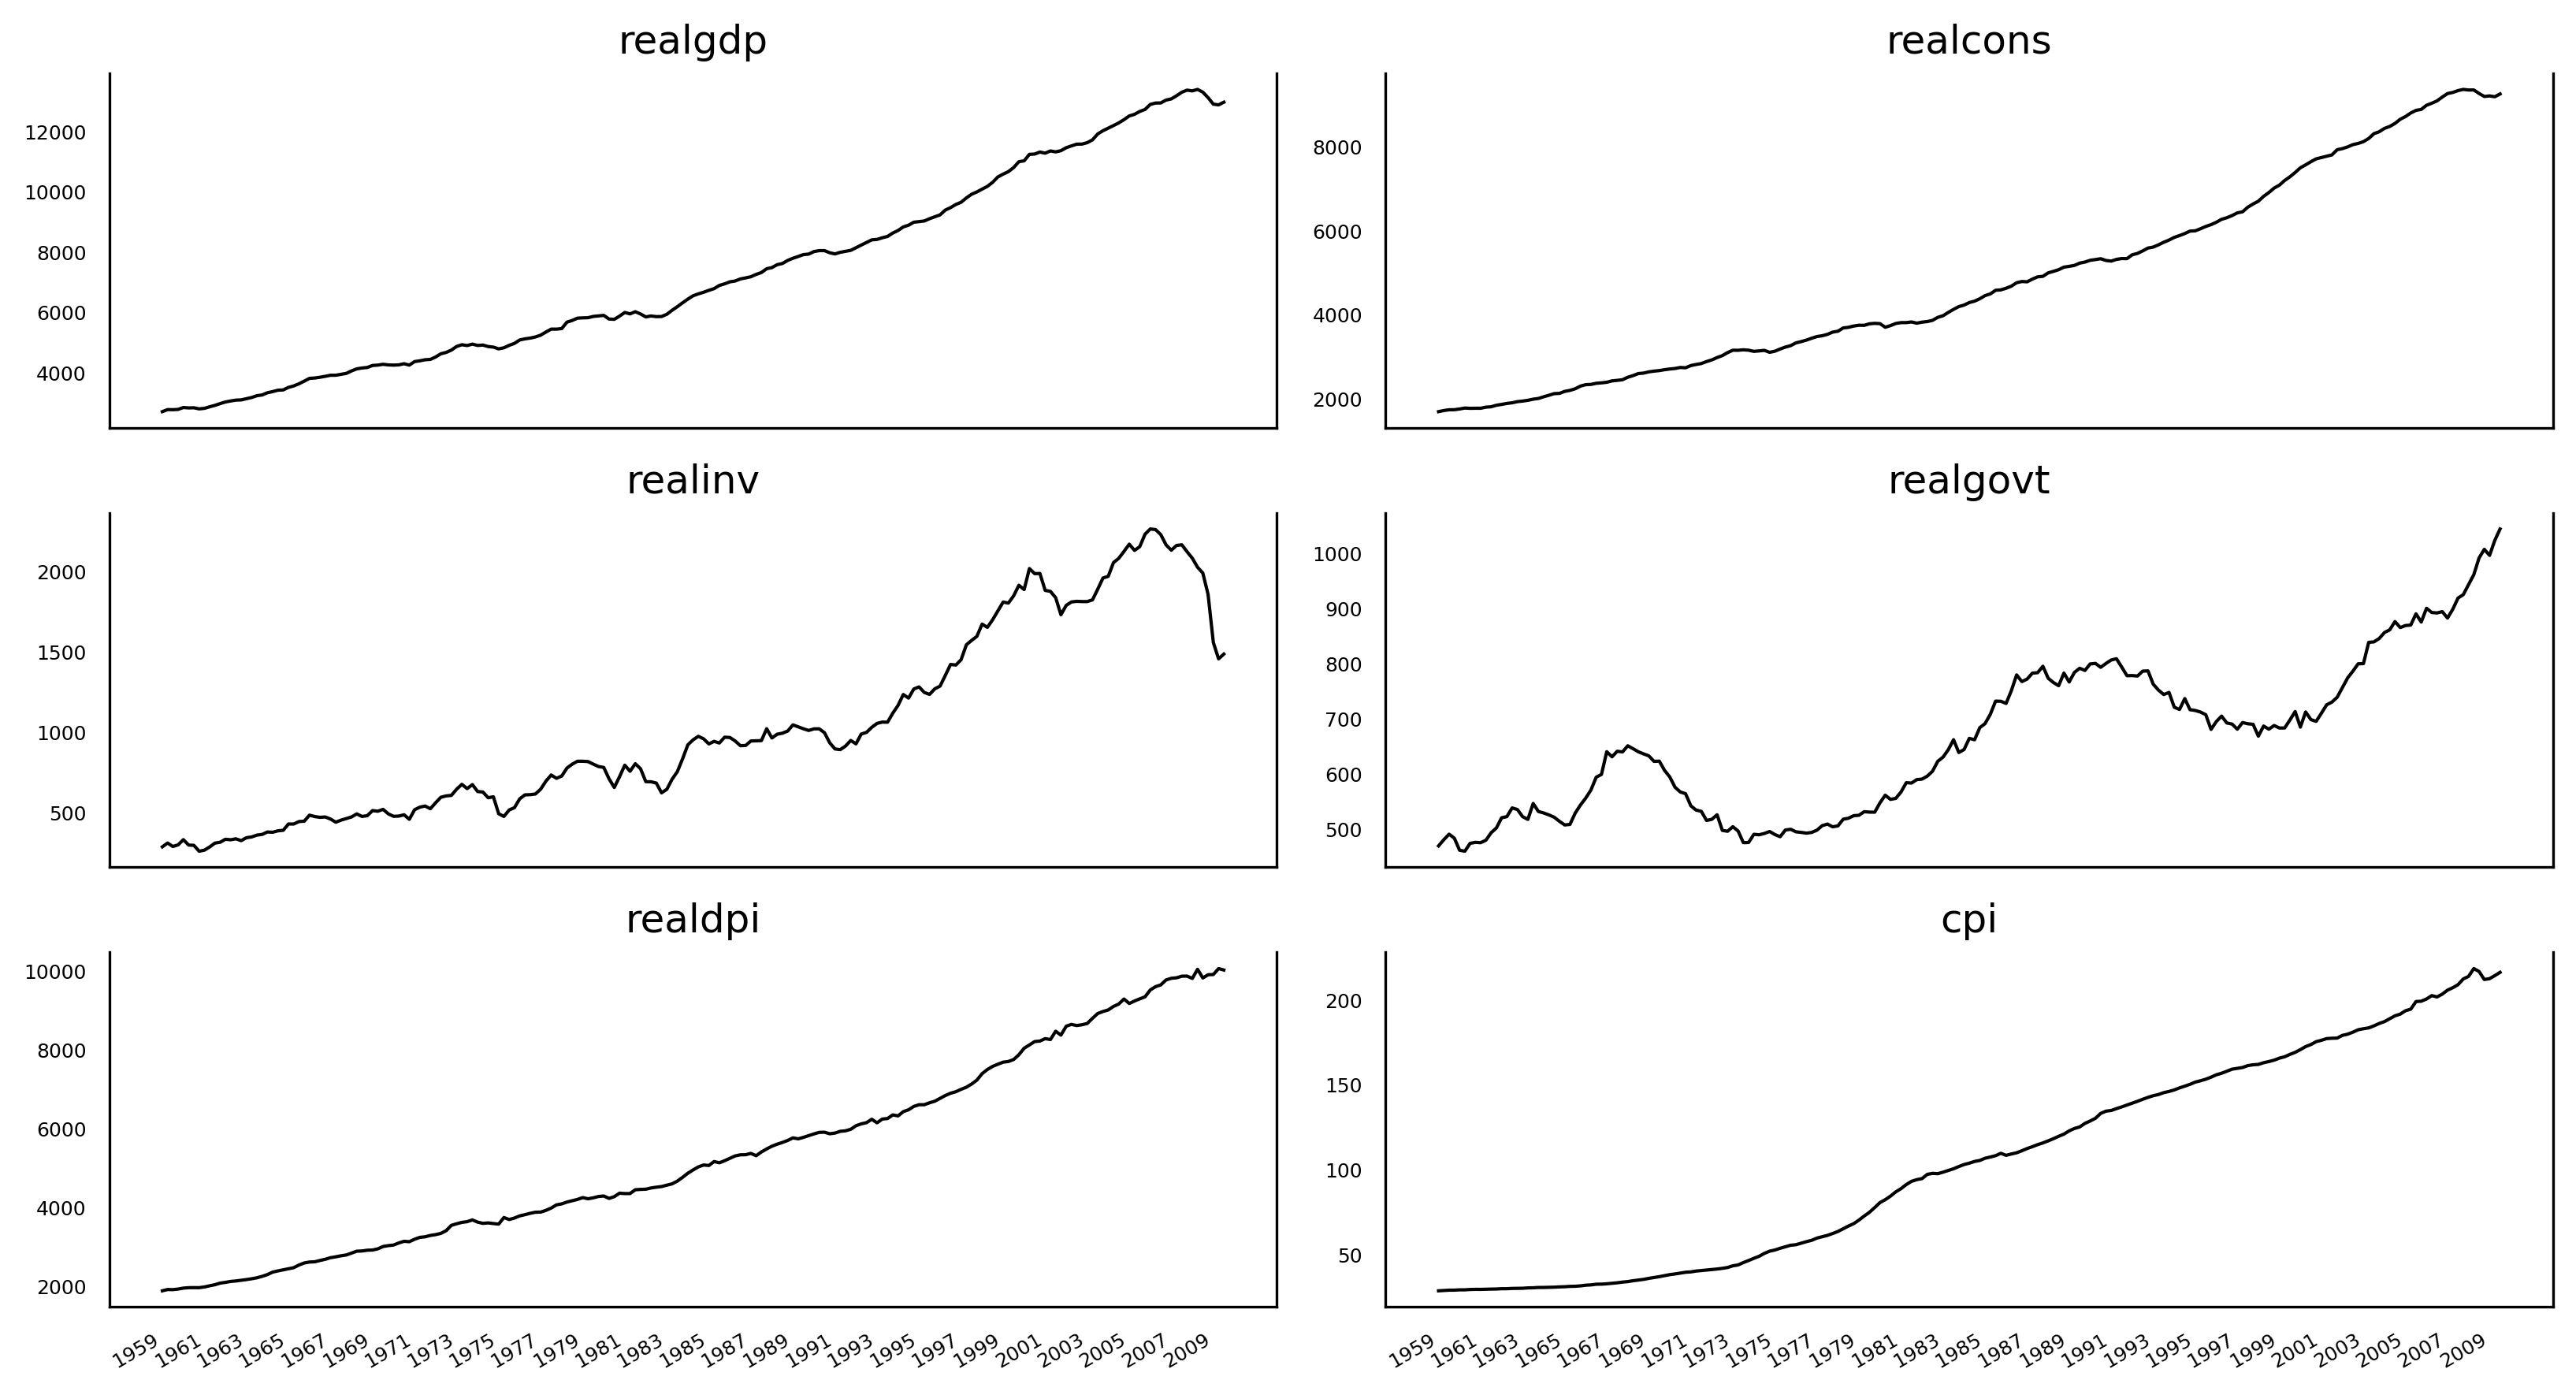

In [77]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))

for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i+2]]

    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()

В качестве целевой переменной — ВВП `realgdp`, в качестве дополнительных переменных — пять других показателей.

In [78]:
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

Преобразуй целевой ряд к стационарному с помощью дифференцирования или других преобразований. Стационарность проверь с помощью расширенного теста Дики — Фуллера (ADF).

In [80]:
# твой код
target_diff = target.diff().dropna()

adf_result = adfuller(target_diff)
print(f'ADF: {adf_result}')

ADF: (-6.305695561658106, 3.327882187668224e-08, 1, 200, {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225}, 2024.992358126391)


Все, ряд получился стационарным, все ок

Раздели исходные данные на обучающую и тестовую выборку.

In [81]:
from sktime.forecasting.model_selection import temporal_train_test_split

In [82]:
# твой код
y_train, y_test = temporal_train_test_split(target, test_size=0.2)
X_train, X_test = temporal_train_test_split(exog, test_size=0.2)

С помощью функции SARIMAX найди лучшую модель отдельно по AIC, МАЕ на тесте и MAPE на тесте. Можешь добавить свои метрики. Выбери одну лучшую модель.

In [90]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from itertools import product

In [92]:
def evaluate_model(y_train, X_train, y_test, X_test, order, seasonal_order):
    try:
        model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
        aic = model_fit.aic
        mae = mean_absolute_error(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions)
        return model_fit, aic, mae, mape
    except Exception as e:
        return 'no_model', float('inf'), float('inf'), float('inf')

p_values = range(0, 4)
d_values = range(0, 1)
q_values = range(0, 4)
P_values = range(0, 3)
D_values = range(0, 1)
Q_values = range(0, 3)
m = 4

param_combinations = list(product(p_values, d_values, q_values, P_values, D_values, Q_values))
best_aic_model, best_mae_model, best_mape_model = 'no_model','no_model', 'no_model'
best_aic, best_mae, best_mape = float("inf"), float("inf"), float("inf")

for params in param_combinations:
    order = (params[0], params[1], params[2])
    seasonal_order = (params[3], params[4], params[5], m)
    model_fit, aic, mae, mape = evaluate_model(y_train, X_train, y_test, X_test, order, seasonal_order)
    if aic < best_aic:
        best_aic_model, best_aic = model_fit, aic
    if mae < best_mae:
        best_mae_model, best_mae = model_fit, mae
    if mape < best_mape:
        best_mape_model, best_mape = model_fit, mape

print(f"Best AIC model {best_aic}")
print(f"Best MAE model {best_mae}")
print(f"Best MAPE model {best_mape}")

Best AIC model 1395.738593634855
Best MAE model 90.38086150221511
Best MAPE model 0.007060812121272133


In [96]:
best_mae_model.aic, best_mape_model.aic

(1481.989382845693, 1481.989382845693)

In [99]:
predictions = best_aic_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
mae, mape

(210.83428331086893, 0.016829038039403325)

Я решила выбрать модель, лучшую по MAE

In [100]:
final_model = best_mae_model
print(final_model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                realgdp   No. Observations:                  162
Model:             SARIMAX(0, 0, 3)x(2, 0, [1, 2], 4)   Log Likelihood                -727.995
Date:                                Sun, 20 Oct 2024   AIC                           1481.989
Time:                                        12:55:45   BIC                           1522.128
Sample:                                             0   HQIC                          1498.286
                                                - 162                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       1.0413      0.082     12.629      0.000       0.880       1.203
rea

Проведи анализ остатков для лучшей модели.

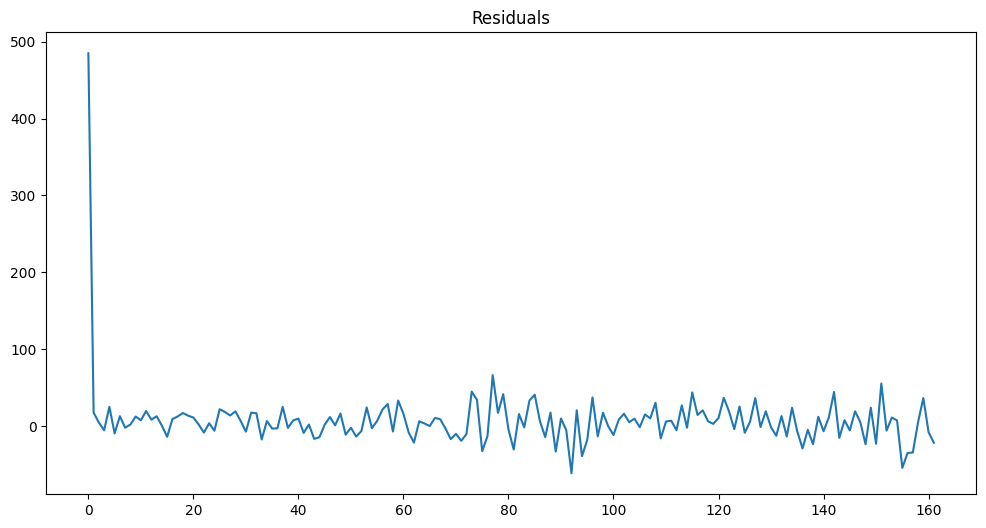

In [101]:
# твой код
residuals = final_model.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title("Residuals")
plt.show()

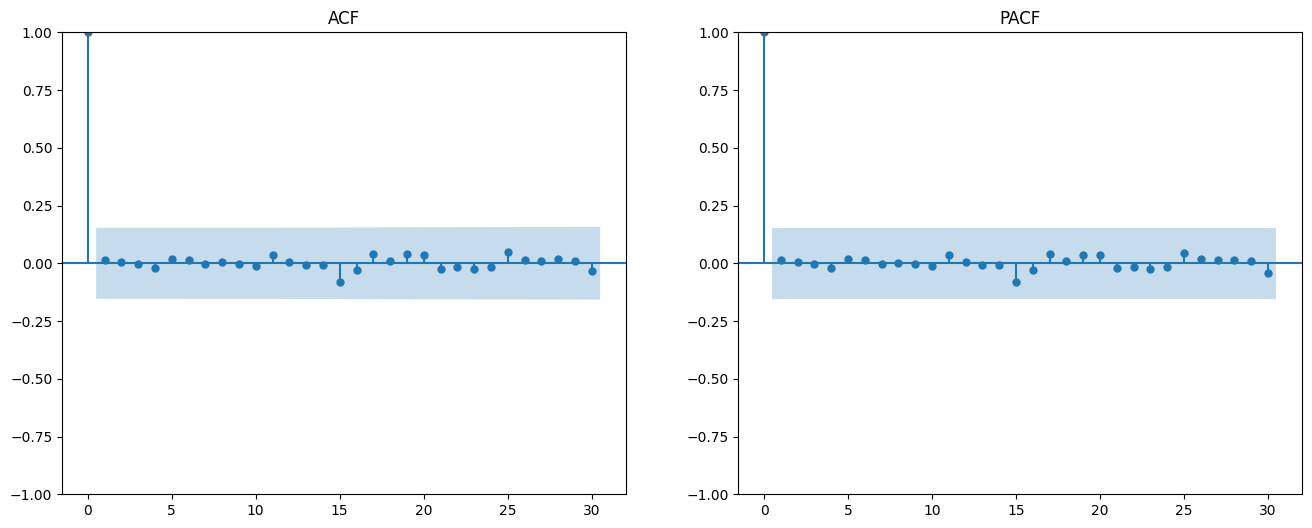

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sm.graphics.tsa.plot_acf(residuals, lags=30, ax=axes[0])
axes[0].set_title("ACF")
sm.graphics.tsa.plot_pacf(residuals, lags=30, ax=axes[1])
axes[1].set_title("PACF")
plt.show()

In [103]:
lb_test = sm.stats.acorr_ljungbox(residuals, lags=[30], return_df=True)
lb_test

,lb_stat,lb_pvalue
30,3.844751,1.0


In [105]:
final_model.resid.mean()

7.3513509489286415

 тест показывает, что модель хорошо справляется с прогнозом, и остатки можно считать случайными. графики в принципе это подтверждают, хотя среднее остатков не равно нулю

Построй графики прогнозов для лучшей модели.

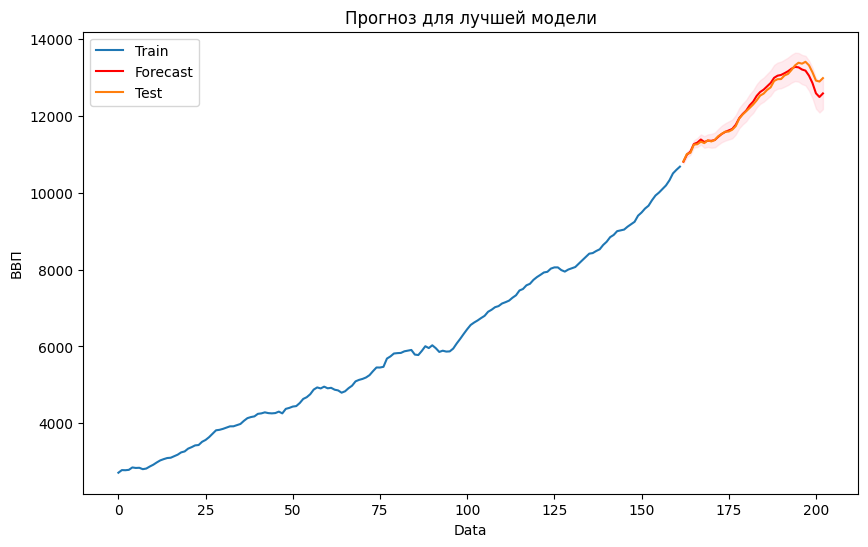

In [107]:
# твой код
forecast_steps = len(y_test)

best_model = final_model
pred = best_model.get_forecast(steps=forecast_steps, exog=X_test)
pred_ci = pred.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(pred.predicted_mean.index, pred.predicted_mean, label="Forecast", color='r')
plt.plot(y_test.index, y_test, label="Test")
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='pink', alpha=0.3)

plt.title("Прогноз для лучшей модели")
plt.xlabel("Data")
plt.ylabel("ВВП")
plt.legend()
plt.show()


Поменяй список дополнительных переменных. Подбери такой набор, чтобы ошибка на тестовой выборке была минимальна. Для этого выбери одну метрику (на твоё усмотрение) для оценки качества на тестовой выборке.

Мы большую часть этой домашки работали с RMSE, решила все-таки тут взять ее

In [109]:
from itertools import combinations

In [115]:
# твой код
exog_vars = ['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']

best_rmse = float('inf')
best_exog_vars = 'none of them'
best_model = 'no model'

for i in range(1, len(exog_vars) + 1):
    for exog_vars_comb in combinations(exog_vars, i):
        try:
            exog_train = X_train[list(exog_vars_comb)]
            exog_test = X_test[list(exog_vars_comb)]
            model = SARIMAX(y_train, exog=exog_train, order=(0, 0, 3), seasonal_order=(2, 0, 1, 4))
            model_fit = model.fit(disp=False)
            predictions = model_fit.forecast(steps=len(y_test), exog=exog_test)
            rmse = np.sqrt(mean_squared_error(y_test, predictions))
            if rmse < best_rmse:
                best_rmse = rmse
                best_exog_vars = exog_vars_comb
                best_model = model_fit
        except Exception as e:
            x = 0
print(f"best combo: {best_exog_vars}, RMSE: {best_rmse}")

best combo: ('realcons', 'realinv', 'realdpi', 'cpi'), RMSE: 120.3451508745289


Если модель изменилась, то проведи анализ остатков и построй графики прогнозов.

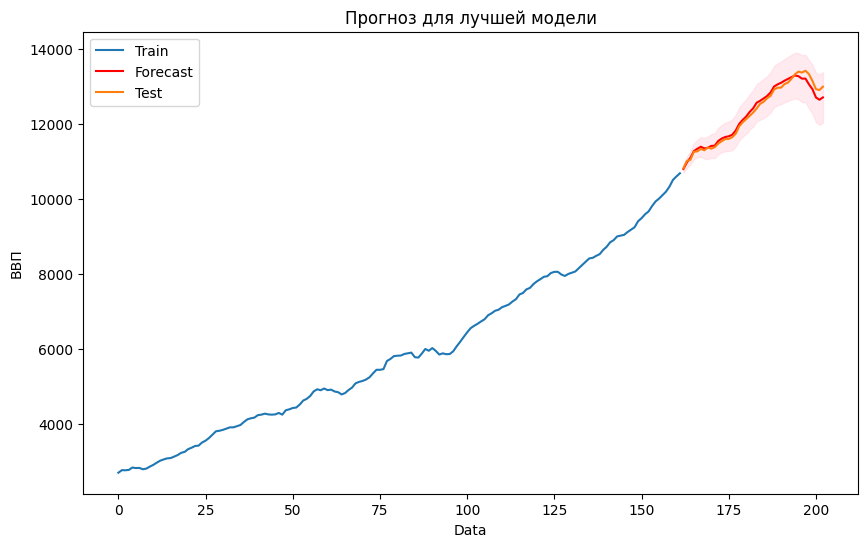

In [116]:
# твой код
forecast_steps = len(y_test)

pred = best_model.get_forecast(steps=forecast_steps, exog=X_test[['realcons', 'realinv', 'realdpi', 'cpi']])
pred_ci = pred.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(pred.predicted_mean.index, pred.predicted_mean, label="Forecast", color='r')
plt.plot(y_test.index, y_test, label="Test")
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='pink', alpha=0.3)

plt.title("Прогноз для лучшей модели")
plt.xlabel("Data")
plt.ylabel("ВВП")
plt.legend()
plt.show()


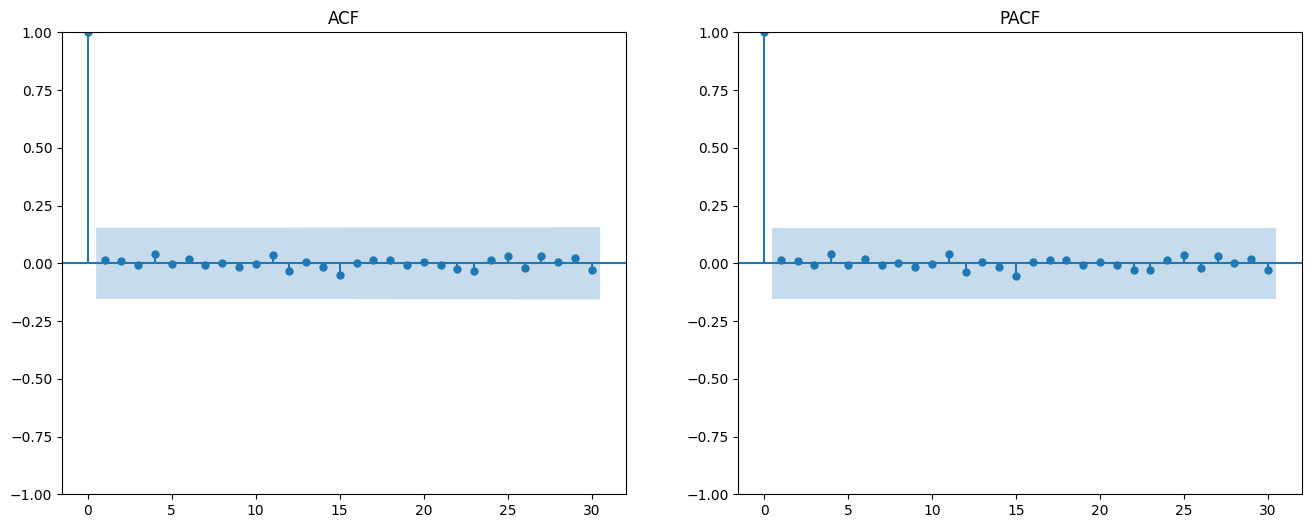

In [117]:
residuals = best_model.resid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sm.graphics.tsa.plot_acf(residuals, lags=30, ax=axes[0])
axes[0].set_title("ACF")
sm.graphics.tsa.plot_pacf(residuals, lags=30, ax=axes[1])
axes[1].set_title("PACF")
plt.show()

In [118]:
lb_test = sm.stats.acorr_ljungbox(residuals, lags=[30], return_df=True)
lb_test

,lb_stat,lb_pvalue
30,2.683494,1.0


In [119]:
residuals.mean()

8.912106500390236

модель тоже хорошая, просто ведет себя чуть иначе, побольше отлоняется в начале, поменьше в конце

#### За лучшую работу начисляется 1 бонусный балл